# Predicting Bike Rentals

Many citites across the United States have communal bike sharing stations and for those who are interested, can rent bicycles by the hour or day. Washington, D.C. collects data on the number of bicycles that are being rented by the hour and day.

For this project, we'll be analyzing a dataset that contains 17,380 rows representing the number of bike rentals for a single hour of a single day. In the dataset, there are columns such as the season, month, weekday vs workday, weather, temperature, etc. We'll implement a few different Machine Learning algorithms to help make predictions as to how many bikes will be rented in any given hour.

We'll begin by importing in the necessary libraries and taking a quick look at the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.sample(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
1626,1627,2011-03-13,1,0,3,7,0,0,0,1,0.36,0.3485,0.62,0.1940,2,8,10
9881,9882,2012-02-21,1,1,2,18,0,2,1,1,0.38,0.3939,0.40,0.4478,11,414,425
11990,11991,2012-05-19,2,1,5,19,0,6,0,1,0.70,0.6364,0.39,0.1343,203,229,432
2115,2116,2011-04-03,2,0,4,0,0,0,0,1,0.30,0.2879,0.65,0.1940,8,31,39
11948,11949,2012-05-18,2,1,5,1,0,5,1,1,0.50,0.4848,0.59,0.0896,16,33,49
15711,15712,2012-10-21,4,1,10,20,0,0,0,1,0.48,0.4697,0.44,0.1940,35,160,195
2829,2830,2011-05-02,2,0,5,19,0,1,1,2,0.62,0.6061,0.69,0.1343,46,268,314
980,981,2011-02-13,1,0,2,12,0,0,0,1,0.36,0.3182,0.32,0.4627,58,94,152
1713,1714,2011-03-17,1,0,3,1,0,4,1,1,0.36,0.3485,0.71,0.2239,1,11,12
17126,17127,2012-12-21,1,1,12,9,0,5,1,2,0.32,0.2727,0.45,0.5522,2,265,267


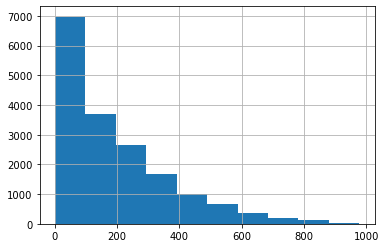

In [3]:
bike_rentals['cnt'].hist()

In [4]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Looking at the histogram for rental count, the graph is heavily right skewed a looking at the distribution values, 75% of all values are less than 300 per day.

In order to begin feature selection and potentially feature engineering, we can take a look at how some correlations with the bike rental count to see if there are any features that stand out.

In [7]:
bike_corr = bike_rentals.corr()['cnt'].abs().sort_values(ascending=False)
bike_corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

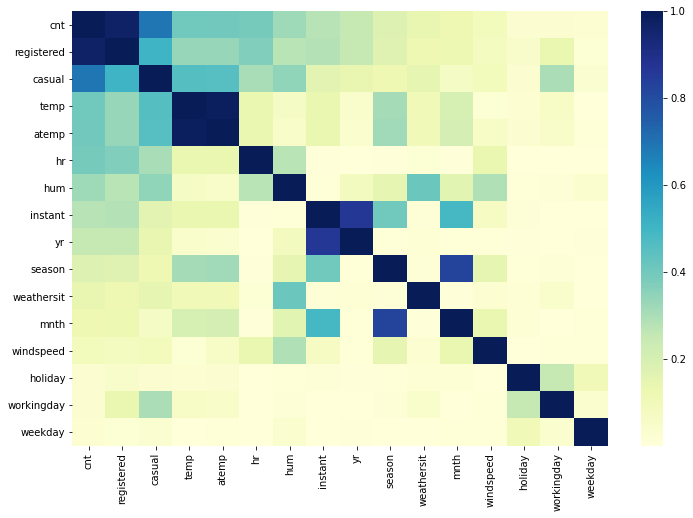

In [8]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(bike_rentals[bike_corr.index].corr().abs(),cmap="YlGnBu")

From the correlations, we can see that <code>'hr'</code> and the columns that relate to temperature and humidity all correlate highly with the overall count. These columns will likely help our model make accurate predictions. <code>'registered'</code> and <code>'casual'</code> refer to the actual riders that are in the count for the day, so we'll ignore those.

### Tweaking Features
For the <code>'hr'</code> column, each hour of the day in representated from 1-24. This is 24 different number values that may cause the machine learning algorithm to learn inefficiently. It will be beneficial to do a bit of engineering to reduce the amount to groups that are related.

We can do this by creating 4 different values, each representing time chunks. 

- 1 if the hour is 6-12
- 2 if the hour is 12-18
- 3 if the hour is 18-24
- 4 if the hour is 0-6

In [9]:
def change_time(val):
    if 0 <= val < 6:
        return 4
    elif 6 <= val < 12:
        return 1
    elif 12 <= val < 18:
        return 2
    else:
        return 3
bike_rentals['time_label'] = bike_rentals['hr'].apply(change_time)

We can grab a sample of the data to make sure our function worked properly.

In [10]:
bike_rentals[['hr','time_label']].sample(5)

,hr,time_label
2125,10,1
7131,18,3
13142,19,3
13945,6,1
3442,8,1


### Splitting the Data
Now that we have the data ready for the algorithms, we need to split the data into a training set to train on, and a test set to test model so we can see the accuracy.

We'll begin with a 80/20 randomized train/test split to test a few different models.

Once we have the data split, we can train the models and compare a few error metrics to see general accuracy. We will use a couple different metrics for this project that work well with regression. The first will be RMSE (root mean squared error). This first takes the difference between the predicted value and the actual values and squares it. This penalizes any predictions that are further away from the acutal value. Then we take the overall mean of these values and then take the square root so we can bring the value back to the original units, in this case rental count. The next error metric will be the r^2 score, which measures the fit of the predicted values vs actual values on a scale from 0 to 1, with 1 being perfect fit and 0 being no fit.

Once we find a potentially best model, we can then run a K-Fold Cross Validation to make sure we weren't overfitting the training data. K-Fold Cross Validation works by segmenting the data in the amount of Folds specified, seperating one fold for the test set and training on the rest. After it trains on this segment, it resets, and repeats the process for each fold making sure each fold is the test set once.

In [11]:
train = bike_rentals.sample(frac = .8, random_state = 1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

### Training Models
We'll begin with a Linear Regression model since this model works well when predictors are linearly correlated with the target and are also independent. Linear Regression works by finding the weights, known as the coefficients, that when applied to the input features, find the lowest error of the predictions to the actual labels.

We'll need to ignore a few columns due to the fact they leak information about our target. These would be <code>'casual'</code> and <code>'registered'</code>. We would only know if the rider is casual or registered once we know a bike has been rented.

We also can remove <code>'dteday'</code> because this is a date and we're focusing a bit more on hours and seasons. We can also remove <code>'atemp'</code> since we already have a column for temperature. Lastly, we'll remove <code>'instant'</code> since this is just an ID.

In [12]:
features = bike_rentals.drop(['cnt','casual','dteday','registered','atemp','instant'], axis = 1).columns
target = ['cnt']

#### Linear Regression Model

In [14]:
lr = LinearRegression()
lr.fit(train[features],train[target])
predictions = lr.predict(test[features])
mse = mean_squared_error(test['cnt'],predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['cnt'],predictions)
print('MSE: ',mse)
print('RMSE: ',rmse)
print('R^2 Score: ',r2)

MSE:  17091.34973731613
RMSE:  130.73388901626132
R^2 Score:  0.4609665470190937


This is a very high error rate and is likely due to the fact that the data has mostly low values with only a handful of high values. Larger errors are penalized higher with mean squared error. Our model seems to be underfitting that data and this is clear with the r^2 score only being .46, which is very low. Given that 75% of the time the amount of riders for the day is less than 300, being potentially off by 130 riders would be very significant.

#### Decision Tree Model
Decision trees tend to predict outcomes a bit better than Linear Regression because Decision Trees can become quite complex. Unfortunately, this can easily result in the model overfitting on the training data. In order to prevent overfitting, tweaking the hyperparameters can help reduce overfitting.

A decision tree is just a binary tree and each node represents a single input variable and a split point on that variable.

The leaf nodes of the tree contain our output variable, the rider count, which is used to make a prediction.  The journey of the Decision Tree follows the branches down and splits down until it arrives at the prediction.

In our first Decision Tree, we won't specify any parameters, just using the defaults from sklearn.

In [16]:
dtr = DecisionTreeRegressor()
dtr.fit(train[features],train[target])
predictions_dtr = dtr.predict(test[features])
mse = mean_squared_error(test['cnt'],predictions_dtr)
rmse_dtr = np.sqrt(mean_squared_error(test['cnt'],predictions_dtr))
r2_dtr = r2_score(test['cnt'],predictions_dtr)
print('MSE: ', mse)
print('RMSE: ',rmse_dtr)
print('R^2 Score: ',r2_dtr)

MSE:  3725.90916283084
RMSE:  61.040225776375046
R^2 Score:  0.8824908674620987


Already the decision tree model is performing significantly better than the linear regression model with the RMSE score less than half and the r^2 score more than doubled. When comparing the MSE score, we can see that it's roughly 4.5 times lower. This means that the predictions were not as far off, otherwise they would have been penalized more aggresively.

When it comes to tuning a model, there are typically are lot hyperparameters that can be tweaked. In Decisicion Tree's there are quite a few. We can change the number of samples required to split an internal node, the depth of the tree can be increased or reduced, we can specify the minimum number of samples required at each leaf node, and we can even change the criterion that measures the quality of the split. This is just a handful of the available options that can help or hurt our model.

A simple, but effective parameter to tweak would be the <code>min_samples_leaf</code>. This refers to the minimum number of samples required to be at a leaf node. Here we can run the model again, with many differnt values for the samples at a leaf node and visualize the training vs test error to see the best trade-off between overfitting and underfitting the data.

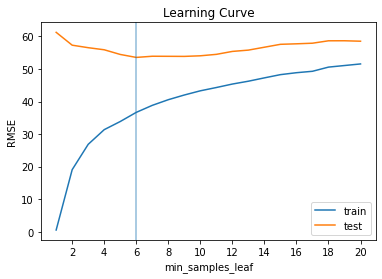

In [25]:
train_rmses = []
test_rmses = []
test_r2s = []
for i in range(1,21):
    dtr = DecisionTreeRegressor(min_samples_leaf = i)
    dtr.fit(train[features],train[target])
    train_predictions_dtr = dtr.predict(train[features])
    test_predictions_dtr = dtr.predict(test[features])
    rmse_train_dtr = np.sqrt(mean_squared_error(train['cnt'],train_predictions_dtr))
    rmse_test_dtr = np.sqrt(mean_squared_error(test['cnt'],test_predictions_dtr))
    r2_test_dtr = r2_score(test['cnt'],test_predictions_dtr)
    train_rmses.append(rmse_train_dtr)
    test_rmses.append(rmse_test_dtr)
    test_r2s.append(r2_test_dtr)

plt.plot([i for i in range(1,21)],train_rmses, label = 'train')
plt.plot([i for i in range(1,21)],test_rmses, label = 'test')
plt.xticks([i for i in range(2,21,2)])
plt.axvline(6, alpha = .5)
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curve')
plt.show()

Looking at the learning curve above. Choosing 6 for the amount of samples per node offers the best trade-off as the test error is at it's lowest point before beginning to increase again.

Let's view the actual RMSE and R^2 values for <code>min_samples_leaf = 6</code>

In [27]:
print('RMSE for 6: ',test_rmses[5])
print('R^2 for 6: ',test_r2s[5])

RMSE for 6:  53.542876796886816
R^2 for 6:  0.9095845265296172


Both metrics are better than our model with the default parameters. Next we can try a random forest to see if we can make any improvements on our predictions.

#### Random Forest
Random Forests tend to be much more accurate than both Linear Regression and Decision Trees. They also tend to be much less susceptible to overfitting due to the fact that they pretty much work as a majority vote with multiple different trees.

Random Forests are an example of an ensemble of decision trees. It works by creating and running multiple different decision trees on different subsets of the training dataset. Each tree tends to overfit slightly each subset, but this allows each tree to be different and have less correlated predictions. Once the model finishes, the predictions from all the trees are averaged.

Let's begin by running the Random Forest model with the default parameters.

In [28]:
rf = RandomForestRegressor()
rf.fit(train[features],train['cnt'])
predictions_rf = rf.predict(test[features])
rmse_rf = np.sqrt(mean_squared_error(test['cnt'],predictions_rf))
r2_rf = r2_score(test['cnt'],predictions_rf)
print('RMSE: ',rmse_rf)
print('R^2 Score: ',r2_rf)

RMSE:  44.40086499811777
R^2 Score:  0.9378240800901121


Running the default Random Forest Regressor from sklearn seems to have performed very well. Looking at the documentation, the default values are as following:
- <code>n_estimators = 100</code> 
- <code>min_samples_leaf = 1</code>
- <code>max_depth = None</code>

With a pretty large drop in RMSE, we'll need to double check to make we weren't overfitting the data. We can accomplish this again by comparing the error metrics amongst the training and test set.

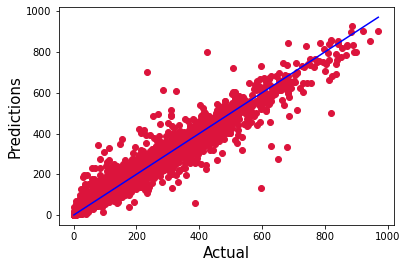

Train RMSE:  15.793853924724843
Train R^2:  0.9924853763072531
------------------------------
Test RMSE:  44.4663078302309
Test R^2:  0.9376406617295602


In [29]:
pd.options.mode.chained_assignment = None  # default='warn'

rf = RandomForestRegressor()
rf.fit(train[features],train['cnt'])
train['predictions'] = rf.predict(train[features])
test['predictions'] = rf.predict(test[features])

train_rmse_rf = np.sqrt(mean_squared_error(train['cnt'],train['predictions']))
train_r2_rf = r2_score(train['cnt'],train['predictions'])

test_rmse_rf = np.sqrt(mean_squared_error(test['cnt'],test['predictions']))
test_r2_rf = r2_score(test['cnt'],test['predictions'])

plt.scatter(test['cnt'],test['predictions'],c='crimson')
p1 = max(max(test['predictions']), max(test['cnt']))
p2 = min(min(test['predictions']), min(test['cnt']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.show()

print('Train RMSE: ', train_rmse_rf)
print('Train R^2: ',train_r2_rf)
print('-'*30)
print('Test RMSE: ', test_rmse_rf)
print('Test R^2: ',test_r2_rf)

Although the predictions in the test set are still pretty accurate and follow the best fit line, we have some predictions that are drastically different than the actual values. Looking at our Train vs Test scores, our model perfromed dramatically better on the training set and thus was overfitting the training data. In the real world, with new data, this model will likely perform even worse on the unseen data than the split test data.

A good option to help tune our Model would be to tweak the hyperparameters. A quick an easy to way to determine which parameters help the model perform the best would be to run a grid search. A grid search utilizes an iterative approach by training the model on a range of given parameters and then scores the model. Once the best combination of parameters has been found, the highest score and tuned model is saved.

In [30]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
        'n_estimators': [4, 6, 9],
        'max_depth': [2, 5, 10],
        'min_samples_leaf': [1, 5, 8],
        'min_samples_split': [2, 3, 5]
    }

grid = GridSearchCV(RandomForestRegressor(),
                           param_grid = hyperparameters,
                           cv = KFold(n_splits = 10,shuffle=True, random_state=1), scoring='r2')
grid.fit(bike_rentals[features],bike_rentals['cnt'])
best_params = grid.best_params_
best_score = grid.best_score_
        
print('Best Parameters: ',best_params)
print('Best Score: ', best_score)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
Best Score:  0.9164939737940543


Using the grid search, with a 10 K-Fold Cross Validation we were able to select our best hyperparameters and achieve an .916 R^2 score. Let's run the Random Forest one more time on our original training/test split with these updated hyperparameters to compare to our previous results.

In [31]:
rf = RandomForestRegressor(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 9)
rf.fit(train[features],train['cnt'])
train['predictions'] = rf.predict(train[features])
test['predictions'] = rf.predict(test[features])

train_rmse_rf = np.sqrt(mean_squared_error(train['cnt'],train['predictions']))
train_r2_rf = r2_score(train['cnt'],train['predictions'])

test_rmse_rf = np.sqrt(mean_squared_error(test['cnt'],test['predictions']))
test_r2_rf = r2_score(test['cnt'],test['predictions'])

print('Train RMSE: ', train_rmse_rf)
print('Train R^2: ',train_r2_rf)
print('-'*30)
print('Test RMSE: ', test_rmse_rf)
print('Test R^2: ',test_r2_rf)

Train RMSE:  44.643288296410404
Train R^2:  0.9399596306110296
------------------------------
Test RMSE:  54.083454900533155
Test R^2:  0.9077496098594794


Although the model still seems to be overfitting the training data a bit with the original split, it isn't as severe as before. 

Reimplementing the K-Fold Cross Validation from the grid search will help reduce the overfitting if this is the final model we'd like to stick with.

## Conclusion
With some basic feature engineering and model tuning, we were able to implement a fairly accurate Random Forest Model to make predictions as to how many bikes will be rented in one day.

In order to make our model even more accurate, we would need to spend more time engineering more features, gathering more data, and potentiallly stacking additional models with the Random Forest. It would also be beneficial to use a holdout set to test our final model on after fitting our model with a K-Fold Cross Validation. This way we can truly test the accuracy on unseen data.